In [1]:
import jax
import jax.numpy as jnp
import numpyro

numpyro.set_host_device_count(
    2
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)  # For 64-bit precision since JAX defaults to 32-bit


import equinox
import matplotlib.pyplot as plt

from numpyro_ext import optim as optimx
from numpyro_ext import distributions as distx

/Users/daniel/code/hoku/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


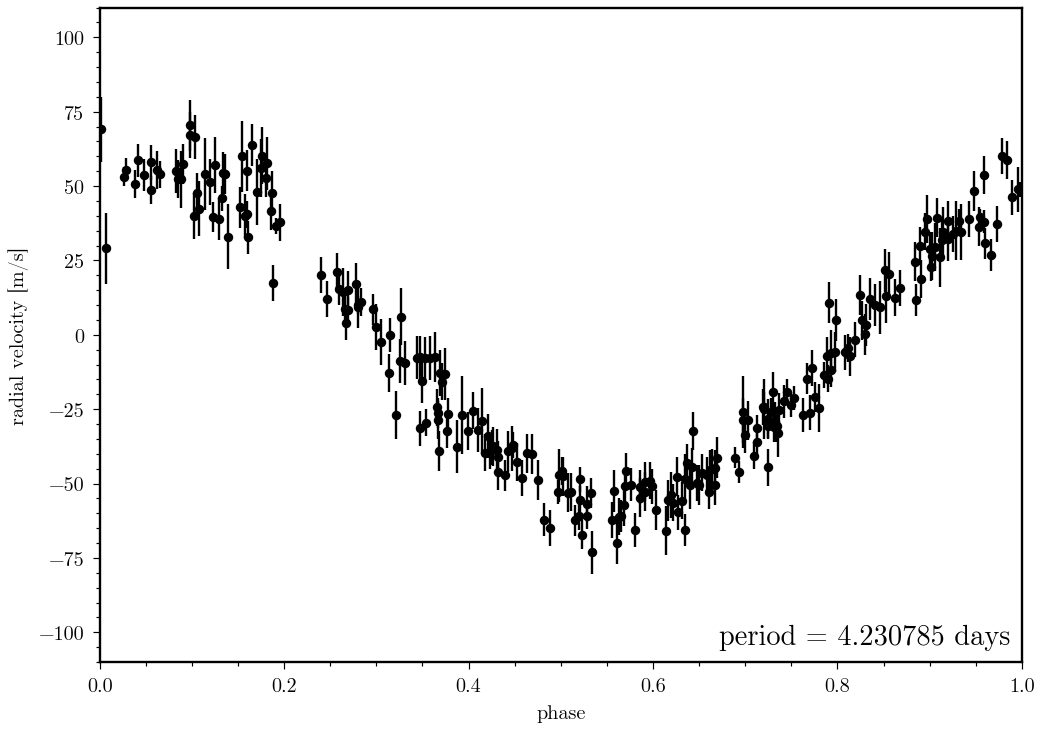

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [
        l.split()
        for l in r.text.splitlines()
        if not l.startswith("\\") and not l.startswith("|")
    ],
    dtype=float,
)
t, rv, rv_err = data.T
t -= np.mean(t)

# Plot the observations "folded" on the published period:
# Butler et al. (2006) https://arxiv.org/abs/astro-ph/0607493
lit_period = 4.230785
plt.errorbar(
    (t % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

In [3]:
import equinox as eqx
# from hoku.core.kepler import kepler
# from exoplanet_core import kepler
from exoplanet_core.jax import ops

# class Orbit(eqx.Module):
#     period: jax.Array
#     t_periastron: jax.Array
#     omega: jax.Array
#     ecc: jax.Array

#     def __init__(self, period=None, t_periastron=None, omega=None, ecc=None):
#         self.period = period
#         self.t_periastron = t_periastron
#         self.omega = omega
#         self.ecc = ecc


#     def _get_true_anomaly(self, t):
#         M = 2.0 * jnp.pi * (t - self.t_periastron) / self.period
#         # if self.ecc is None:
#         #     return jnp.sin(M), jnp.cos(M)
#         sinf, cosf = ops.kepler(M, self.ecc + jnp.zeros_like(M))
#         return jnp.arctan2(sinf, cosf)

#     def get_radial_velocity(self, t, K):
#         f = self._get_true_anomaly(t)
#         cosf = jnp.cos(f)
#         sinf = jnp.sin(f)
        
#         return jnp.squeeze(
#             K
#             * (
#                 jnp.cos(self.omega) * cosf
#                 - jnp.sin(self.omega) * sinf
#                 + self.ecc * jnp.cos(self.omega)
#             )
#         )

In [4]:
t = jnp.asarray(t)

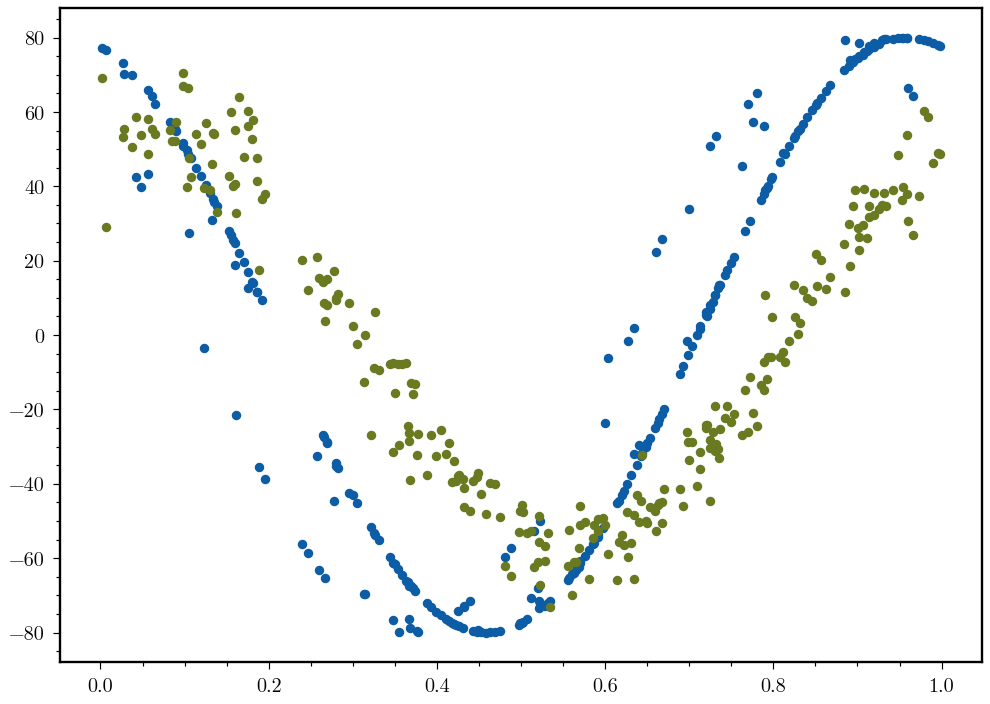

In [25]:
orbit = Orbit(4.23, 0.1, 0.5, 0.)
# t = jnp.linspace(0, 100, 1000)
xgrid = jnp.linspace(0, 100, 1000)
plt.plot(t % lit_period / lit_period, orbit.get_radial_velocity(t, 80), '.')
plt.plot(t % lit_period / lit_period, rv, '.')

In [5]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
# from hoku.core.kepler import kepler
# 
# Define the probabilistic model using NumPyro
def model(x, yerr, y=None):
    # Priors for the slope and intercept
    period = numpyro.sample("period", dist.Normal(lit_period, 0.1))
    log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(jnp.mean(yerr)), 10))

    ecc = numpyro.sample('ecc', distx.UnitDisk())
    eccen = numpyro.deterministic('eccen', jnp.sum(ecc**2))
    omega = numpyro.sample("omega", distx.Angle())
    phi = numpyro.sample("phi", distx.Angle())

    # t_periastron = numpyro.sample('t_periastron', dist.)
    
    logK = numpyro.sample(
        "logK", dist.Uniform(0, jnp.log(200))
    )
    K = numpyro.deterministic('K', jnp.exp(logK))

    # n = 2 * jnp.pi * (-1*period)
    # t0 = (phi + omega) / n

    # Equinox model
    # orbit = Orbit(period = period,
    #               t_periastron=t0,
    #               omega=omega,
    #               ecc = None)
    
    M = 2.0 * jnp.pi * t / period - phi
    # M = 2.0 * jnp.pi * (t - self.t_periastron) / self.period
    sinf, cosf = ops.kepler(M, eccen + jnp.zeros_like(M))
    f = jnp.arctan2(sinf, cosf)

    cosf = jnp.cos(f)
    sinf = jnp.sin(f)

    y_pred = jnp.squeeze(
        K
        * (
            jnp.cos(omega) * cosf
            - jnp.sin(omega) * sinf
            + eccen * jnp.cos(omega)
        )
    )
    
    
    rv0 = numpyro.sample('rv0', dist.Normal(0, 10))
    rvtrend = numpyro.sample('rvtrend', dist.Normal(0, 10))
    bkg = numpyro.deterministic("bkg", rv0 + rvtrend * x / 365.25)

    # y_pred = orbit.get_radial_velocity(x, K)
    numpyro.deterministic('pred', y_pred)
    #   Predicted values
    with numpyro.plate('data', len(x)):
        numpyro.sample("obs", dist.Normal(y_pred + bkg, yerr**2 + jnp.exp(2 * log_jitter)), obs=y)
    
    # Likelihood (Gaussian noise)
    

In [6]:
key = jax.random.PRNGKey(0)

soln = optimx.optimize(
    model,
    #    start=None,
    return_info=False,
)(key, t, rv_err, y=rv)

In [7]:
soln

{'period': Array(4.14974787, dtype=float64),
 'log_jitter': Array(0.85168395, dtype=float64),
 'ecc': Array([-0.03763699, -0.17075172], dtype=float64),
 'omega': Array(-3.03048309, dtype=float64),
 'phi': Array(-0.27545367, dtype=float64),
 'logK': Array(3.65230787, dtype=float64),
 'rv0': Array(-1.76335647, dtype=float64),
 'rvtrend': Array(-4.25462627, dtype=float64),
 'K': Array(38.56356294, dtype=float64),
 'bkg': Array([  2.59828412,   2.59806694,   2.5967171 ,   2.59653375,
          2.59491751,   2.59475937,   2.58726832,   2.58708752,
          2.58690039,   2.58604279,   2.58585755,   2.58568282,
          2.58405931,   2.58387932,   2.58370729,   2.57573241,
          2.57552473,   2.57359356,   2.57217326,   2.56404965,
          2.56040227,   2.56024184,   2.49384816,   2.49355655,
          2.49157333,   2.4913134 ,   2.48227459,   2.48201183,
          2.47956456,   2.47929882,   2.47076803,   2.47050054,
          2.46831766,   2.4680925 ,   2.4588895 ,   2.45863508,
   

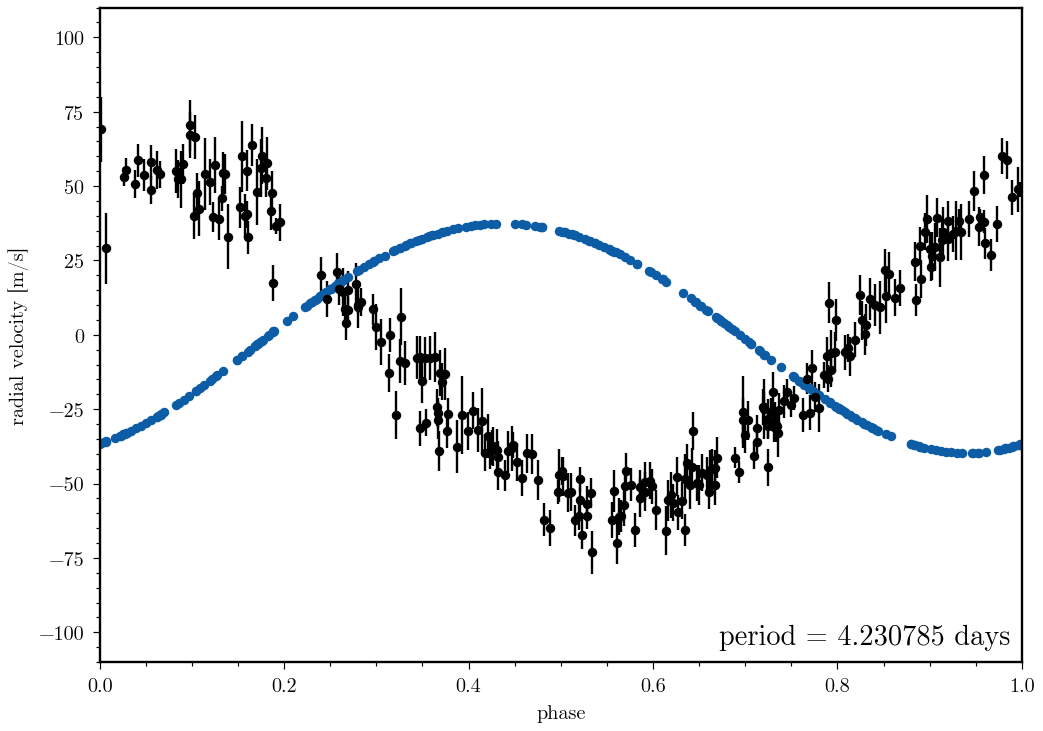

In [12]:
plt.errorbar(
    ((t) % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

# Now let's overplot the initial solution:
# plt.plot((t) % soln['period'] / soln['period'], soln['pred'], '.')
plt.plot((t) % (soln['period']) / soln['period'], soln['pred'], '.')
# plt.plot(t, )
# plt.plot(t % soln['period'] / soln['period'], soln['pred'], '.')

In [13]:
from numpyro import infer

nuts_kernel = infer.NUTS(
    model,
    # target_accept_prob=0.9,
    # dense_mass=True,
    init_strategy=infer.init_to_value(values=soln),
    # regularize_mass_matrix=False,
    # max_tree_depth=10
)
sampler = infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=2,
    progress_bar=True,
    jit_model_args=True
)

# Start profiling
# from tensorflow.python.profiler import trace
# jax.profiler.start_trace('tensorlog')

# Run your NumPyro model or any JAX computations here
sampler.run(jax.random.PRNGKey(42), t, rv_err, y=rv)

# Stop profiling after the model runs
# jax.profiler.stop_trace()



Running chain 0:   0%|          | 0/6000 [00:01<?, ?it/s]

In [14]:
sampler.print_summary()

Running chain 0: 100%|██████████| 6000/6000 [00:38<00:00, 155.18it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      ecc[0]     -0.01      0.23     -0.01     -0.37      0.35   3809.36      1.00
      ecc[1]     -0.00      0.22     -0.00     -0.35      0.36   3879.50      1.00
        logK      3.78      0.12      3.80      3.60      3.96      1.60      1.49
  log_jitter     -3.23      5.72      0.56    -12.25      1.15      1.78      1.57
       omega     -0.81      2.10     -1.84     -3.14      2.66      4.28      1.12
      period      4.16      0.02      4.15      4.14      4.17      1.03      5.43
         phi     -0.26      2.24     -0.73     -2.94      3.09    146.12      1.02
         rv0     -0.20      2.16     -0.21     -3.75      3.30   2531.06      1.00
     rvtrend     -3.14      1.38     -3.08     -5.40     -0.89      2.19      1.27

Number of divergences: 19


In [10]:
from numpyro import infer

nuts_kernel = infer.NUTS(
    model,
    # target_accept_prob=0.9,
    # dense_mass=True,
    init_strategy=infer.init_to_value(values=soln),
    # regularize_mass_matrix=False,
    # max_tree_depth=10
)
sampler = infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=2,
    progress_bar=True,
    jit_model_args=True
)

# Start profiling
# from tensorflow.python.profiler import trace
# jax.profiler.start_trace('tensorlog')

# Run your NumPyro model or any JAX computations here
sampler.run(jax.random.PRNGKey(42), t, rv_err, y=rv)

# Stop profiling after the model runs
# jax.profiler.stop_trace()



2024-10-05 16:09:53.075321: E external/xla/xla/python/profiler/internal/python_hooks.cc:400] Can't import tensorflow.python.profiler.trace
Running chain 0:   0%|          | 0/6000 [00:01<?, ?it/s]2024-10-05 16:09:55.226519: E external/xla/xla/python/profiler/internal/python_hooks.cc:400] Can't import tensorflow.python.profiler.trace


Running chain 1: 100%|██████████| 6000/6000 [00:39<00:00, 150.53it/s]


In [74]:
sampler.print_summary(exclude_deterministic=True)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      ecc[0]      0.00      0.14      0.00     -0.22      0.22   6357.76      1.00
      ecc[1]      0.00      0.13      0.00     -0.22      0.22   6777.19      1.00
        logK      3.94      0.05      3.94      3.86      4.02   7072.07      1.00
  log_jitter     -7.85      5.48     -6.64    -15.84     -0.41   3251.36      1.00
       omega      0.61      0.11      0.60      0.43      0.78   1005.80      1.00
      period      4.22      0.00      4.22      4.22      4.22   8634.12      1.00
         phi      0.10      1.83      0.15     -2.48      3.14    877.96      1.00
         rv0     -2.15      1.84     -2.17     -5.32      0.73   7190.04      1.00
     rvtrend     -2.05      1.02     -2.04     -3.78     -0.42   6838.72      1.00

Number of divergences: 0


In [10]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from hoku.core.kepler import kepler
# 
# Define the probabilistic model using NumPyro
def model(x, yerr, y=None):
    # Priors for the slope and intercept
    period = numpyro.sample("period", dist.Normal(lit_period, 0.1))
    log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(jnp.mean(yerr)), 10))

    ecc = numpyro.sample('ecc', distx.UnitDisk())
    eccen = numpyro.deterministic('eccen', jnp.sum(ecc**2))
    omega = numpyro.sample("omega", distx.Angle())
    phi = numpyro.sample("phi", distx.Angle())

    # t_periastron = numpyro.sample('t_periastron', dist.)
    
    logK = numpyro.sample(
        "logK", dist.Uniform(0, jnp.log(200))
    )
    K = numpyro.deterministic('K', jnp.exp(logK))

    n = 2 * jnp.pi * (-1*period)
    t0 = (phi + omega) / n

    # Equinox model
    # orbit = Orbit(period = period,
    #               t_periastron=t0,
    #               omega=omega,
    #               ecc = eccen)
    
    M = 2.0 * jnp.pi * (t - t0) / period
    sinf, cosf = kepler(M, eccen)
    f = jnp.arctan2(sinf, cosf)
    cosf = jnp.cos(f)
    sinf = jnp.sin(f)
    y_pred = K * (
                jnp.cos(omega) * cosf
                - jnp.sin(omega) * sinf
                + eccen * jnp.cos(omega)
            )
    
    rv0 = numpyro.sample('rv0', dist.Normal(0, 10))
    rvtrend = numpyro.sample('rvtrend', dist.Normal(0, 10))
    bkg = numpyro.deterministic("bkg", rv0 + rvtrend * x / 365.25)

    # Predicted values
    # y_pred = orbit.get_radial_velocity(x, K)
    
    numpyro.deterministic('pred', y_pred)
    # Likelihood (Gaussian noise)
    numpyro.sample("obs", dist.Normal(y_pred + bkg, yerr**2 + jnp.exp(2 * log_jitter)), obs=y)


In [11]:
key = jax.random.PRNGKey(0)

soln = optimx.optimize(
    model,
    #    start=None,
    return_info=False,
)(key, t, rv_err, y=rv)

In [13]:
from numpyro import infer

nuts_kernel = infer.NUTS(
    model,
    target_accept_prob=0.9,
    dense_mass=True,
    init_strategy=infer.init_to_value(values=soln),
    # regularize_mass_matrix=True,
    # max_tree_depth=10
)
sampler = infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
    jit_model_args=True
)
sampler.run(jax.random.PRNGKey(42), t, rv_err, y=rv)

Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████| 2000/2000 [01:09<00:00, 28.85it/s]


In [21]:
sampler.print_summary(exclude_deterministic=True)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      ecc[0]     -0.00      0.13     -0.01     -0.23      0.21    401.19      1.00
      ecc[1]      0.00      0.13     -0.00     -0.19      0.25    308.49      1.00
        logK      3.94      0.05      3.94      3.85      4.02    484.50      1.00
  log_jitter     -7.55      5.11     -6.48    -15.23     -0.41    359.89      1.00
       omega      0.61      0.12      0.62      0.43      0.79     33.49      1.09
      period      4.22      0.00      4.22      4.22      4.22   1519.27      1.00
         phi     -0.07      1.95     -0.17     -3.03      2.73     39.38      1.09
         rv0     -2.13      1.85     -2.14     -4.89      1.07    267.16      1.00
     rvtrend     -2.00      1.01     -2.00     -3.64     -0.38    534.26      1.00

Number of divergences: 0


In [24]:
samples = sampler.get_samples()


In [19]:
import arviz as az
az.summary(
    samples, vars=['K']
)

ModuleNotFoundError: No module named 'arviz'

In [9]:
import equinox as eqx
import jax.numpy as jnp
import jax

# Linear model definition with Equinox
class LinearModel(eqx.Module):
    slope: float
    intercept: float

    def __init__(self, slope=0.0, intercept=0.0):
        self.slope = slope
        self.intercept = intercept

    def __call__(self, x):
        return self.slope * x + self.intercept


In [10]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Define the probabilistic model using NumPyro
def model(x, y=None):
    # Priors for the slope and intercept
    slope = numpyro.sample("slope", dist.Normal(0, 10))
    intercept = numpyro.sample("intercept", dist.Normal(0, 10))
    
    # Equinox linear model
    lin_model = LinearModel(slope=slope, intercept=intercept)
    
    # Predicted values
    y_pred = lin_model(x)
    
    # Likelihood (Gaussian noise)
    numpyro.sample("obs", dist.Normal(y_pred, 1.0), obs=y)


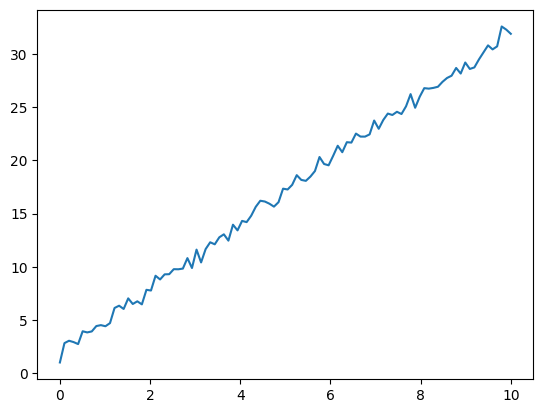

In [11]:
# Generate synthetic data: y = 3x + 2 + noise
key = jax.random.PRNGKey(0)
x_data = jnp.linspace(0, 10, 100)
true_slope = 3.0
true_intercept = 2.0
y_data = true_slope * x_data + true_intercept + 0.5 * jax.random.normal(key, shape=x_data.shape)
plt.plot(x_data, y_data)

In [12]:
# Set up NUTS sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)

# Run MCMC to sample from the posterior
mcmc.run(jax.random.PRNGKey(1), x=x_data, y=y_data)

# Get the samples
posterior_samples = mcmc.get_samples()


sample: 100%|██████████| 3000/3000 [00:00<00:00, 3142.38it/s, 1 steps of size 4.40e-01. acc. prob=0.89] 
